This is the minimal implementation of this solution of Petfinder Pawpularity, The number of folds, epochs and other models selection are reduced due to longer time training, but the overall strategy is demonstrated, The basic overview of the methods are consist of two parts.
### Overview
 Part 1 has extraction of features from different pretrained imagenet model with 1000 classes. These models were picked without finetuning and then SVR is added for the final evaluation. The models were selected based on the RMSE evaluation with climb hilling strategy, Initially each model RMSE is caclulated and then out of those, the best model is picked for initial inclusion, then other models are picked and combined with the first and RMSE is calculated again, If the inclusion of second decreases RMSE, then that is included to selected list otherwise next model is picked and so on. For part 2, efficient and transformer models were used including swin, beit with different data augmentations. In the end, both models from part 1 and part2 ensembled for final prediction. 
 ### Reason for good performance
 The author used different imagenet models without finetuning in part 1 and then Support Vector Regression is used after the final output of imagenet models. It is due to the pretrained models are trained on imagenet and they already can work on pets, so that's why author did not fine tune the pretrained models in part 1. In part 2, the author added the Neural Network Head to the last layer and fine tune the models. Additionally, the author used different types of data augmentation to make the model diverse. 

 ### Difference to my model
 I tried to use single model but after reviewing the top perfomer's solution, I came to know that, they have used more than dozen's of models and then stack/ensemble their results. which make them diverse. 

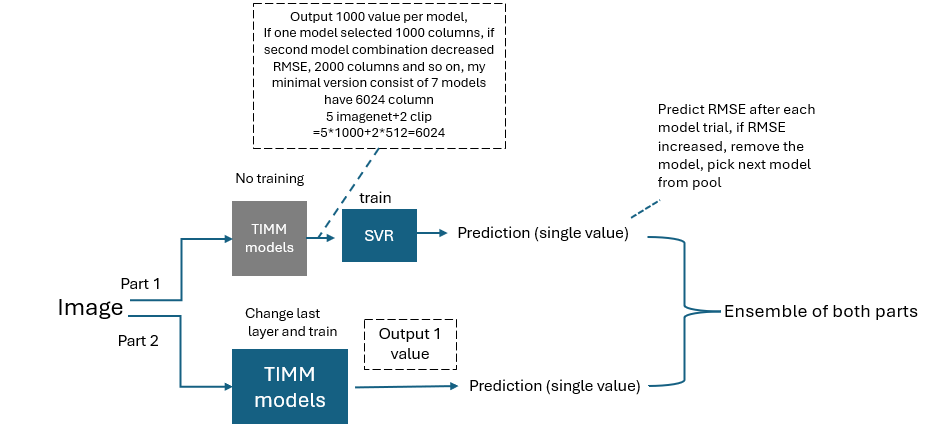

## Part 1
using imagenet models and CLIP model without finetuning their last layer. Just adding the SVR on top 

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import time
import gc
import clip
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import cuml
from cuml.svm import SVR
import albumentations as A
from torch import nn
import joblib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# --------------------------------------------------------------
# 1. Load Train Data + Create 2 Stratified Folds for testing purpose
# --------------------------------------------------------------
BASE_PATH = "inputs/"                     
train = pd.read_csv(BASE_PATH + 'train.csv')  # Id, Pawpularity, ...

# Build full image paths
train['file'] = train['Id'].apply(lambda x: f'{BASE_PATH}train/{x}.jpg')


# Stratified folds
train['bin'] = (train['Pawpularity'] // 5).round()
train['fold'] = -1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for i, (_, val_idx) in enumerate(skf.split(train, train['bin'])):
    train.loc[val_idx, 'fold'] = i
train['fold'] = train['fold'].astype(int)


In [4]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file,bin,fold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,inputs/train/0007de18844b0dbbb5e1f607da0606e0.jpg,12,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,inputs/train/0009c66b9439883ba2750fb825e1d7db.jpg,8,1
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,inputs/train/0013fd999caf9a3efe1352ca1b0d937e.jpg,5,2
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,inputs/train/0018df346ac9c1d8413cfcc888ca8246.jpg,3,4
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,inputs/train/001dc955e10590d3ca4673f034feeef2.jpg,14,0


In [6]:
print(train.groupby('fold')['Pawpularity'].agg(['mean', 'std', 'count']))

           mean        std  count
fold                             
0     38.008573  20.596146   1983
1     38.044377  20.648811   1983
2     38.030272  20.569874   1982
3     38.076186  20.541330   1982
4     38.035822  20.624310   1982


In [7]:
# --------------------------------------------------------------
# 2. Dataset (reads full path only)
# --------------------------------------------------------------
class PawDataset(Dataset):
    def __init__(self, file_list, transform=None, hflip=False, crop_pct=0.98):
        self.file_list = file_list
        self.transform = transform
        self.hflip = hflip
        self.crop_pct = crop_pct

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx]).convert('RGB')
        if self.hflip:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            img = img.crop((0, 0.02 * h, self.crop_pct * w, self.crop_pct * h))
        if self.transform:
            img = self.transform(img)
        return img

In [39]:
# --------------------------------------------------------------
# 3. Model Discovery: Filter Strong Families
# --------------------------------------------------------------
all_pretrained = timm.list_models(pretrained=True)
print(f"Total pretrained: {len(all_pretrained)}")

candidate_models = [
    'deit_base_distilled_patch16_384',
    'ig_resnext101_32x48d',
    'vit_base_patch16_384',
    'tf_efficientnet_b6_ns',
    'ig_resnext101_32x8d',
    'tf_efficientnet_b6_ns_hflip_384',
]

print(f"Candidates: {len(candidate_models)}, unique:{len(np.unique(candidate_models))}")

# CLIP
clip_candidates = ['RN101', 'ViT-B/16']



print(f"Total models to explore TIMM + CLIP: {len(candidate_models) + len(clip_candidates)}")

Total pretrained: 1689
Candidates: 6, unique:6
Total models to explore TIMM + CLIP: 8


In [ ]:
#these are the models which we will explore and apply hill climbing to find the best subset
candidate_models

['deit_base_distilled_patch16_384',
 'ig_resnext101_32x48d',
 'vit_base_patch16_384',
 'tf_efficientnet_b6_ns',
 'ig_resnext101_32x8d',
 'tf_efficientnet_b6_ns_hflip_384']

In [ ]:
# --------------------------------------------------------------
# 4. Feature Extraction (Train-Only, OOF)
# --------------------------------------------------------------
import time
EMB_OOF = {}      # Out-of-fold features
dimensions = {}

#  extract OOF features (5-fold)
def extract_oof_timm(arch):
    model = timm.create_model(arch, pretrained=True).to(device).eval()
    cfg = timm.data.resolve_data_config({}, model=model)
    transform = timm.data.create_transform(**cfg)
    dim = 1000
    dimensions[arch] = dim

    

    oof_feat = np.zeros((len(train), dim), dtype=np.float32)
    for fold in range(5):
        val_idx = train['fold'] == fold
        val_files = train.loc[val_idx, 'file'].values
        ds = PawDataset(val_files, transform=transform)
        dl = DataLoader(ds, batch_size=16, num_workers=2, shuffle=False)
        feats = []
        with torch.no_grad():
            for batch in tqdm(dl, desc=f"{arch} fold {fold}"):
                feats.append(model(batch.to(device)))
        oof_feat[val_idx] = torch.cat(feats, dim=0).cpu().numpy()
    del model, ds, dl
    torch.cuda.empty_cache()
    gc.collect()
    return oof_feat



# Extract
start = time.time()
for arch in [m for m in candidate_models if '_hflip_' not in m]:
    print(f"Extracting OOF: {arch}")
    EMB_OOF[arch] = extract_oof_timm(arch)


# time calculation func
def calcTime(startTime):
    end = time.time()
    total_seconds = int(end - startTime)
    hours, remainder = divmod(total_seconds, 3600)
    minutes = remainder // 60
    return hours,minutes


hours, minutes = calcTime(start)
print(f"Total runtime: {hours}h {minutes}m")


Extracting OOF: deit_base_distilled_patch16_384


deit_base_distilled_patch16_384 fold 4: 100%|██████████| 124/124 [02:32<00:00,  1.23s/it]


Extracting OOF: ig_resnext101_32x48d


/home/ghias/miniconda3/envs/rapids-env/lib/python3.10/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name ig_resnext101_32x48d to current resnext101_32x8d.fb_wsl_ig1b_ft_in1k.
  model = create_fn(
ig_resnext101_32x48d fold 4: 100%|██████████| 124/124 [00:13<00:00,  9.03it/s]


Extracting OOF: vit_base_patch16_384


vit_base_patch16_384 fold 4: 100%|██████████| 124/124 [00:39<00:00,  3.15it/s]


Extracting OOF: tf_efficientnet_b6_ns


/home/ghias/miniconda3/envs/rapids-env/lib/python3.10/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b6_ns to current tf_efficientnet_b6.ns_jft_in1k.
  model = create_fn(
tf_efficientnet_b6_ns fold 4: 100%|██████████| 124/124 [00:47<00:00,  2.62it/s]


Extracting OOF: ig_resnext101_32x8d


/home/ghias/miniconda3/envs/rapids-env/lib/python3.10/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name ig_resnext101_32x8d to current resnext101_32x8d.fb_wsl_ig1b_ft_in1k.
  model = create_fn(
ig_resnext101_32x8d fold 4: 100%|██████████| 124/124 [00:13<00:00,  9.01it/s]


Total runtime: 0h 22m


In [74]:
# time calculation func
import time
def calcTime(startTime):
    end = time.time()
    total_seconds = int(end - startTime)
    hours, remainder = divmod(total_seconds, 3600)
    minutes = remainder // 60
    print(f"Total runtime: {hours}h {minutes}m")





In [52]:
EMB_OOF['deit_base_distilled_patch16_384'].shape

(9912, 1000)

In [53]:
def extract_oof_clip(name):
    model, preprocess = clip.load(name, device=device)
    model.eval()
    dim = model.visual.output_dim
    dimensions[f'clip_{name}'] = dim

    oof_feat = np.zeros((len(train), dim), dtype=np.float32)
    for fold in range(5):
        val_idx = train['fold'] == fold
        val_files = train.loc[val_idx, 'file'].values
        ds = PawDataset(val_files, transform=preprocess)
        dl = DataLoader(ds, batch_size=64, num_workers=2, shuffle=False)
        feats = []
        with torch.no_grad():
            for batch in tqdm(dl, desc=f"{arch} fold {fold}"):
                feats.append(model.encode_image(batch.to(device)))
        oof_feat[val_idx] = torch.cat(feats, dim=0).cpu().numpy()
    del model
    torch.cuda.empty_cache()
    gc.collect()
    return oof_feat


for m in clip_candidates:
    name = f'clip_{m}'
    print(f"Extracting OOF: {name}")
    EMB_OOF[name] = extract_oof_clip(m)

Extracting OOF: clip_RN101


ig_resnext101_32x8d fold 4: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


Extracting OOF: clip_ViT-B/16


ig_resnext101_32x8d fold 4: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]


In [ ]:
# Hflip
start=time.time()
for arch in [m for m in candidate_models if '_hflip_' in m]:
    base, sz = arch.split('_hflip_')
    sz = int(sz)
    print(f"Extracting OOF: {arch}")
    model = timm.create_model(base, pretrained=True).to(device).eval()
    cfg = timm.data.resolve_data_config({}, model=model)
    cfg['input_size'] = (3, sz, sz)
    cfg['crop_pct'] = 1.0
    transform = timm.data.create_transform(**cfg)
    dim = 1000
    dimensions[arch] = dim

    oof_feat = np.zeros((len(train), dim), dtype=np.float32)
    for fold in range(5):
        val_idx = train['fold'] == fold
        val_files = train.loc[val_idx, 'file'].values
        ds = PawDataset(val_files, transform=transform, hflip=True)
        dl = DataLoader(ds, batch_size=16, num_workers=0, shuffle=False)
        feats = []
        with torch.no_grad():
            for batch in dl:
                feats.append(model(batch.to(device)))
        oof_feat[val_idx] = torch.cat(feats, dim=0).cpu().numpy()
    EMB_OOF[arch] = oof_feat
    del model
    torch.cuda.empty_cache()
    gc.collect()

hours, minutes = calcTime(start)
print(f"Total runtime: {hours}h {minutes}m")
joblib.dump(EMB_OOF, 'saved_models/emb_oof.pkl')
joblib.dump(dimensions, 'saved_models/dimensions.pkl')
print("OOF features saved.")

Extracting OOF: tf_efficientnet_b6_ns_hflip_384


/home/ghias/miniconda3/envs/rapids-env/lib/python3.10/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b6_ns to current tf_efficientnet_b6.ns_jft_in1k.
  model = create_fn(


Total runtime: 0h 2m
OOF features saved.


In [61]:
for i,key in enumerate(EMB_OOF):
    print(f" {key}, shape: {EMB_OOF[key].shape}")


 deit_base_distilled_patch16_384, shape: (9912, 1000)
 ig_resnext101_32x48d, shape: (9912, 1000)
 vit_base_patch16_384, shape: (9912, 1000)
 tf_efficientnet_b6_ns, shape: (9912, 1000)
 ig_resnext101_32x8d, shape: (9912, 1000)
 clip_RN101, shape: (9912, 512)
 clip_ViT-B/16, shape: (9912, 512)
 tf_efficientnet_b6_ns_hflip_384, shape: (9912, 1000)


In [79]:
# --------------------------------------------------------------
# 5. Single-Model CV (OOF RMSE)
# --------------------------------------------------------------
import time
def rmse(y, p):
    return np.sqrt(np.mean((y - p) ** 2))

def cv_svr(X):
    oof = np.zeros(len(train))
    for fold in range(5):
        tr_idx = train['fold'] != fold
        val_idx = train['fold'] == fold
        svr = SVR(C=16.0, kernel='rbf', max_iter=4000,degree=3)
        svr.fit(X[tr_idx], train['Pawpularity'].loc[tr_idx].clip(1,85))
        oof[val_idx] = np.clip(svr.predict(X[val_idx]), 1, 100)
        del svr
        gc.collect()
    return oof

single_rmse = {}
single_oof = {}  # to save OOF predictions

start=time.time()
for name, feat in EMB_OOF.items(): 
    # Standardize features
    X = StandardScaler().fit_transform(feat)
    # Get OOF predictions using 5-fold CV
    pred = cv_svr(X)
    # Save RMSE
    single_rmse[name] = rmse(train['Pawpularity'], pred)
    
    # Save OOF predictions
    single_oof[name] = pred

calcTime(start)

# Sort models by RMSE
sorted_models = sorted(single_rmse.items(), key=lambda x: x[1])

for n, r in sorted_models:
    print(f"{n:40} {r:.4f}")

# Save results to disk
joblib.dump(single_rmse, 'saved_models/single_rmse.pkl')
joblib.dump(single_oof, 'saved_models/single_oof_preds.pkl')
print("Simple average:", round(np.mean(list(single_rmse.values())), 4))

Total runtime: 0h 0m
tf_efficientnet_b6_ns                    17.6591
clip_ViT-B/16                            17.7128
deit_base_distilled_patch16_384          17.7218
tf_efficientnet_b6_ns_hflip_384          17.7458
ig_resnext101_32x48d                     17.8070
ig_resnext101_32x8d                      17.8070
vit_base_patch16_384                     17.9099
clip_RN101                               17.9745
Simple average: 17.7922


In [ ]:
def stack(selected):
    X = np.hstack([EMB_OOF[m] for m in selected])
    return StandardScaler().fit_transform(X)

def cv_rmse_stack(selected, return_pred=False):
    X = stack(selected)
    oof_pred = cv_svr(X)
    score = rmse(train['Pawpularity'], oof_pred)
    if return_pred:
        return score, oof_pred
    else:
        return score

def forward_hill_climb_verbose(start_with):
    sel = [start_with]
    best, best_pred = cv_rmse_stack(sel, return_pred=True)
    print(f"\n{'='*80}")
    print(f"START MODEL: {start_with}")
    print(f"Initial RMSE: {best:.4f}")
    print(f"{'-'*60}")

    log = []
    step = 1

    while True:
        remaining = [m for m in EMB_OOF if m not in sel]
        if not remaining:
            break

        improved = False
        for candidate in remaining:
            score, _ = cv_rmse_stack(sel + [candidate], return_pred=True)
            status = "ADDED" if score < best else "SKIPPED "
            log.append({
                'Step': step,
                'Tried Model': candidate,
                'RMSE': score,
                'Status': status
            })
            if score < best:
                best = score
                sel.append(candidate)
                improved = True
                print(f"  + Added: {candidate} | RMSE improved to {best:.4f}")
                break
            else:
                print(f"    x Tried: {candidate} | RMSE worse ({score:.4f})")

        if not improved:
            break
        step += 1

    print(f"{'-'*80}")
    print(f"Final selected models: {sel}")
    print(f"Final RMSE: {best:.4f}")
    print(f"{'='*80}\n")

    log_df = pd.DataFrame(log)
    return sel, best, best_pred, log_df


#  best single model
best_start = sorted_models[0][0]
best_sel, best_rmse, best_pred, log_df = forward_hill_climb_verbose(best_start)

# Save 
np.save("best_oof_pred.npy", best_pred)
pd.DataFrame({'Selected_Models': best_sel}).to_csv("best_models.csv", index=False)
pd.DataFrame({'RMSE': [best_rmse]}).to_csv("best_rmse.csv", index=False)
log_df.to_csv("forward_hillclimb_log.csv", index=False)

print(f" Best RMSE: {best_rmse:.4f}")
print(f" Selected Models: {best_sel}")



START MODEL: tf_efficientnet_b6_ns
Initial RMSE: 17.6591
------------------------------------------------------------
  + Added: deit_base_distilled_patch16_384 | RMSE improved to 17.4735
  + Added: ig_resnext101_32x48d | RMSE improved to 17.4196
  + Added: vit_base_patch16_384 | RMSE improved to 17.4059
    x Tried: ig_resnext101_32x8d | RMSE worse (17.4224)
  + Added: clip_RN101 | RMSE improved to 17.3284
    x Tried: ig_resnext101_32x8d | RMSE worse (17.3459)
  + Added: clip_ViT-B/16 | RMSE improved to 17.2598
    x Tried: ig_resnext101_32x8d | RMSE worse (17.2775)
  + Added: tf_efficientnet_b6_ns_hflip_384 | RMSE improved to 17.2482
    x Tried: ig_resnext101_32x8d | RMSE worse (17.2635)
--------------------------------------------------------------------------------
Final selected models: ['tf_efficientnet_b6_ns', 'deit_base_distilled_patch16_384', 'ig_resnext101_32x48d', 'vit_base_patch16_384', 'clip_RN101', 'clip_ViT-B/16', 'tf_efficientnet_b6_ns_hflip_384']
Final RMSE: 17.2482

In [ ]:
# Show the columns (features) of the final stacked table
X_final = stack(best_sel)

#  DataFrame for preview
cols = []
for m in best_sel:
    dim = EMB_OOF[m].shape[1]
    cols.extend([f"{m}_f{i}" for i in range(dim)])

df_preview = pd.DataFrame(X_final, columns=cols)

print("\nStacked feature table shape:", df_preview.shape)
not_selected = [m for m in EMB_OOF if m not in best_sel]
print("final selected", best_sel)
print("not selected in hill climbing round", not_selected)



Stacked feature table shape: (9912, 6024)
final selected ['tf_efficientnet_b6_ns', 'deit_base_distilled_patch16_384', 'ig_resnext101_32x48d', 'vit_base_patch16_384', 'clip_RN101', 'clip_ViT-B/16', 'tf_efficientnet_b6_ns_hflip_384']
not selected in hill climbing round ['ig_resnext101_32x8d']


In [88]:
# our intial pool for models consist of 8 , then after hill climbing 7 were selected, now out of these 7, five were from imagenet pretrained with 1000 classes
# and 2 models were from clip with 512 dim, so total should be 1000*5+512*2 = 5000+1024 = 6024 which are shown above

In [89]:
import numpy as np

# Load the file
best_pred = np.load("best_oof_pred.npy")

# Check the shape
print(best_pred.shape)

# See first 10 values
print(best_pred[:10])


(9912,)
[51.58178711 36.76829529 42.69537354 47.5320816  43.52454376 72.70659637
 32.36867523 43.38385773 67.40782166 30.02429199]


## Part 2
Now we will apply the part 2, where we will finetune swin transformer, once it is trained , then we will ensemble both

In [ ]:
class PetDataset(Dataset):
    def __init__(self, image_paths, targets, transform=None):
        self.image_paths = image_paths
        self.targets = targets  
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'target': torch.tensor(self.targets[idx], dtype=torch.float)
        }

In [ ]:
# --------------------------------------------------------------
#  Transforms using Albumentations
# --------------------------------------------------------------
def get_transforms(img_size=224, aug_type='light', is_train=True):
    if is_train:
        if aug_type == 'light':
            return A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
            ])
        else:  # heavy
            return A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=20, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.HueSaturationValue(p=0.3),
               
            ])
    else:
        return A.Compose([A.Resize(img_size, img_size)])



In [161]:
# --------------------------------------------------------------
# Model Definition
# --------------------------------------------------------------
class PetModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=1)
    
    def forward(self, x):
        return self.model(x).squeeze(-1)  # Return shape: [batch_size]


In [ ]:

# --------------------------------------------------------------
#  Training Function with BCE Loss
# --------------------------------------------------------------
def train_dl_model(model_name, train_df, n_epochs=5, batch_size=16, img_size=224,
                   aug_type='light', lr=1e-4, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    n_folds = 5
    oof_preds = np.zeros(len(train_df), dtype=float)

    for fold in range(n_folds):
        print(f"\n{'='*70}")
        print(f"Model: {model_name} | Fold {fold+1}/{n_folds}")
        print(f"{'='*70}")
        
        # Split data
        tr_ind = train_df['fold'] != fold
        val_ind = train_df['fold'] == fold
        
        tr_paths = train_df.loc[tr_ind, 'file'].values
        tr_targets = train_df.loc[tr_ind, 'Pawpularity'].values / 100.0  # Normalize to 0-1
        
        val_paths = train_df.loc[val_ind, 'file'].values
        val_targets_normalized = train_df.loc[val_ind, 'Pawpularity'].values / 100.0  # For dataset
        val_targets_original = train_df.loc[val_ind, 'Pawpularity'].values  # For RMSE calculation

        # Create datasets
        train_dataset = PetDataset(tr_paths, tr_targets, 
                                   transform=get_transforms(img_size, aug_type, is_train=True))
        val_dataset = PetDataset(val_paths, val_targets_normalized, 
                                 transform=get_transforms(img_size, aug_type, is_train=False))

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, 
                                num_workers=4, pin_memory=True)

        # Model, loss, optimizer
        model = PetModel(model_name, pretrained=True).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1)

        best_val_rmse = float('inf')
        best_val_preds = None
        patience = 0
        max_patience = 3

        for epoch in range(n_epochs):
            # ========== Training ==========
            model.train()
            train_loss = 0.0
            train_count = 0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
                imgs = batch['image'].to(device)
                tgts = batch['target'].to(device)  
                
                optimizer.zero_grad()
                logits = model(imgs)  
                loss = criterion(logits, tgts)  
                loss.backward()
                
               
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item() * len(imgs)
                train_count += len(imgs)
            
            avg_train_loss = train_loss / train_count
            scheduler.step()

            # ========== Validation ==========
            model.eval()
            val_preds = []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Valid]"):
                    imgs = batch['image'].to(device)
                    logits = model(imgs)  # Raw logits
                    probs = torch.sigmoid(logits)  
                    scaled = probs * 100.0  
                    val_preds.extend(scaled.cpu().numpy())

            val_preds = np.array(val_preds)
            val_preds = np.clip(val_preds, 1, 100)  # Clip to valid range
            
            # Calculate RMSE on original scale (0-100)
            val_rmse = np.sqrt(np.mean((val_targets_original - val_preds) ** 2))
            
         

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_preds = val_preds.copy()
                torch.save(model.state_dict(), 
                          os.path.join(save_dir, f"{model_name}_fold{fold}.pth"))
                patience = 0
                print(f"   Best model saved! RMSE: {val_rmse:.4f}")
            else:
                patience += 1
                if patience >= max_patience:
                    print(f"  Early stopping triggered (patience={max_patience})")
                    break

        # Store best predictions for this fold
        oof_preds[val_ind.values] = best_val_preds
        print(f"\nFold {fold+1} Complete | Best Val RMSE: {best_val_rmse:.4f}")
        
        # Cleanup
        del model, optimizer, scheduler, train_dataset, val_dataset, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    # Calculate overall OOF RMSE
    overall_rmse = np.sqrt(np.mean((train_df['Pawpularity'].values - oof_preds) ** 2))
    print(f"\n{'='*70}")
    print(f"{model_name} - Overall OOF RMSE: {overall_rmse:.4f}")
    print(f"{'='*70}")
    
    # Save OOF predictions
    np.save(os.path.join(save_dir, f"oof_{model_name}.npy"), oof_preds)
    return oof_preds, overall_rmse



In [165]:
# --------------------------------------------------------------
# Models (Single Model for Testing)
# --------------------------------------------------------------
import time 
part2_models = [
    {"name": "swin_base_patch4_window7_224", "size": 224, "aug": "light", "lr": 1e-4, "epochs": 5},
]

# --------------------------------------------------------------
#  Train All Part 2 Models
# --------------------------------------------------------------

print("PART 2: FINE-TUNING DEEP LEARNING MODELS")


cnn_oofs = {}
cnn_rmses = {}

start_time = time.time()

for cfg in part2_models:
    name = cfg["name"]
    print(f"\n{'#'*80}")
    print(f"Starting Training: {name}")
    print(f"{'#'*80}")
    
    oof, rmse = train_dl_model(
        model_name=name,
        train_df=train,
        n_epochs=cfg.get("epochs", 2),
        batch_size=24,
        img_size=cfg["size"],
        aug_type=cfg["aug"],
        lr=cfg["lr"],
        save_dir="saved_models"
    )
    cnn_oofs[name] = oof
    cnn_rmses[name] = rmse



PART 2: FINE-TUNING DEEP LEARNING MODELS

################################################################################
Starting Training: swin_base_patch4_window7_224
################################################################################

Model: swin_base_patch4_window7_224 | Fold 1/5


Epoch 1/5 [Valid]: 100%|██████████| 42/42 [00:37<00:00,  1.13it/s]


   Best model saved! RMSE: 19.1161


Epoch 3/5 [Valid]: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s]


   Best model saved! RMSE: 18.4653


Epoch 5/5 [Valid]: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s]



Fold 1 Complete | Best Val RMSE: 18.4653

Model: swin_base_patch4_window7_224 | Fold 2/5


Epoch 1/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]


   Best model saved! RMSE: 20.6497


Epoch 3/5 [Valid]: 100%|██████████| 42/42 [00:15<00:00,  2.80it/s]


   Best model saved! RMSE: 19.0544


Epoch 5/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]


   Best model saved! RMSE: 18.8400

Fold 2 Complete | Best Val RMSE: 18.8400

Model: swin_base_patch4_window7_224 | Fold 3/5


Epoch 1/5 [Valid]: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]


   Best model saved! RMSE: 20.8172


Epoch 2/5 [Valid]: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]


   Best model saved! RMSE: 18.8477


Epoch 3/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.82it/s]


   Best model saved! RMSE: 18.4833


Epoch 5/5 [Valid]: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]



Fold 3 Complete | Best Val RMSE: 18.4833

Model: swin_base_patch4_window7_224 | Fold 4/5


Epoch 1/5 [Valid]: 100%|██████████| 42/42 [00:15<00:00,  2.78it/s]


   Best model saved! RMSE: 18.6381


Epoch 3/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.83it/s]


   Best model saved! RMSE: 18.2070


Epoch 5/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.84it/s]



Fold 4 Complete | Best Val RMSE: 18.2070

Model: swin_base_patch4_window7_224 | Fold 5/5


Epoch 1/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.82it/s]


   Best model saved! RMSE: 20.5738


Epoch 2/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.84it/s]


   Best model saved! RMSE: 18.3561


Epoch 5/5 [Valid]: 100%|██████████| 42/42 [00:14<00:00,  2.81it/s]


  Early stopping triggered (patience=3)

Fold 5 Complete | Best Val RMSE: 18.3561

swin_base_patch4_window7_224 - Overall OOF RMSE: 18.4716


In [166]:


calcTime(start_time)



Total runtime: 1h 52m


In [171]:
cnn_oofs.values()

dict_values([array([45.73020935, 34.84912872, 42.49206924, ..., 26.63207436,
       37.21738434, 40.15033722], shape=(9912,))])

In [ ]:
# ================================================================
#  Ensemble weights finding
# ================================================================

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --------------------------
# Load OOF predictions
# --------------------------
part1_oof = np.load("best_oof_pred.npy")  # Part 1 OOFs
part2_oof = np.load("saved_models/oof_swin_base_patch4_window7_224.npy")  # Part 2 OOFs
y_true = train["Pawpularity"].values

# --------------------------
# Define unconstrained loss function
# --------------------------
def min_func(K):
    y_pred = K[0]*part1_oof + K[1]*part2_oof
    return rmse(y_true, y_pred)

# --------------------------
# Optimize weights
# --------------------------
init_w = [0.5, 0.5]
res = minimize(min_func, init_w, method="Nelder-Mead", tol=1e-6)
K = res.x
print("Optimized weights (unconstrained):", K)

# --------------------------
# Final ensemble prediction
# --------------------------
final_pred = K[0]*part1_oof + K[1]*part2_oof
final_rmse = rmse(y_true, final_pred)

print(f"Final Ensemble OOF RMSE: {final_rmse:.4f}")
print("Normalized weight ratio:", K / np.sum(K))


Optimized weights (unconstrained): [0.74853708 0.29222934]
Final Ensemble OOF RMSE: 17.4587
Normalized weight ratio: [0.71921717 0.28078283]
